In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CSV 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/result_after_cluster.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4863 entries, 0 to 4862
Data columns (total 56 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   기준_년_코드           4863 non-null   int64  
 1   기준_분기_코드          4863 non-null   int64  
 2   상권_코드             4863 non-null   int64  
 3   소득_구간_코드          4863 non-null   float64
 4   지출_총금액            4863 non-null   int64  
 5   식료품_지출_총금액        4863 non-null   int64  
 6   의류_신발_지출_총금액      4863 non-null   int64  
 7   의료비_지출_총금액        4863 non-null   int64  
 8   교통_지출_총금액         4863 non-null   int64  
 9   여가_지출_총금액         4863 non-null   int64  
 10  문화_지출_총금액         4863 non-null   int64  
 11  교육_지출_총금액         4863 non-null   int64  
 12  유흥_지출_총금액         4863 non-null   int64  
 13  상권_변화_지표          4863 non-null   int64  
 14  운영_영업_개월_평균       4863 non-null   int64  
 15  폐업_영업_개월_평균       4863 non-null   int64  
 16  서울_운영_영업_개월_평균    4863 non-null   int64  


In [ ]:
df.head()

,기준_년_코드,기준_분기_코드,상권_코드,소득_구간_코드,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,의료비_지출_총금액,교통_지출_총금액,여가_지출_총금액,...,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수,상권_구분_코드_D,상권_구분_코드_R,젠트리_여부,clust
0,2022,4,3110026,5.0,1279480368,384953823,149819310,188300820,188770501,42519168,...,0,0,0,0,0,0,0,0,0,2
1,2022,4,3110023,7.0,1218624917,326224874,156085506,151287708,182538503,44779326,...,0,0,0,0,0,2,0,0,0,2
2,2022,4,3110014,8.0,1969736582,479930572,238888198,240951589,333249120,77311288,...,0,0,0,0,0,2,0,0,1,2
3,2022,4,3110011,9.0,1108089226,269053880,135168215,138376366,191978815,43819085,...,0,0,0,0,0,1,0,0,0,2
4,2022,4,3110006,8.0,1940079660,491926934,239390891,254076343,330198770,80828910,...,0,0,0,0,0,2,0,0,0,2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# GPU를 사용할 수 있다면 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 불러오기
X = df.iloc[:,3:].drop('clust', axis=1).values  # target을 제외한 특성들
y = df['clust'].values

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-Hot Encoding
y_onehot = pd.get_dummies(pd.Series(y))

# 훈련 데이터와 검증 데이터로 나누기
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_onehot.values, test_size=0.2, random_state=42)

# 데이터를 PyTorch의 Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# 데이터 로더 설정
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([3890, 52])
torch.Size([3890, 4])


# Transformer 모델 정의

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate):
        super(TransformerModel, self).__init__()

        # Multihead Attention 레이어
        self.self_attention = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)

        # Feedforward 레이어
        self.feedforward = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)

        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(input_size)
        self.layer_norm2 = nn.LayerNorm(input_size)

        # Fully Connected 레이어 (분류를 위한)
        self.fc = nn.Linear(input_size, output_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # 어텐션 레이어 통과
        attention_output, _ = self.self_attention(x, x, x)
        x = x + self.dropout(attention_output)
        x = self.layer_norm1(x)

        # Feedforward 레이어 통과
        ff_output = self.feedforward(x)
        x = x + self.dropout(ff_output)
        x = self.layer_norm2(x)

        # Fully Connected 레이어 통과 (softmax를 사용하지 않음)
        x = self.fc(x)
        return x


    def get_attention_weights(self, x):
        # 어텐션 레이어 통과
        attention_output, weights = self.self_attention(x, x, x)
        return weights


# 모델 초기화 및 손실 함수, 옵티마이저 설정
input_size = X_train.shape[1]  # 입력 데이터의 특성 수
hidden_size = 128  # Feedforward 레이어의 히든 크기
output_size = y_train.shape[1]  # 클래스 수
num_layers = 2  # 트랜스포머 레이어의 수
num_heads = 4  # 어텐션 헤드의 수
dropout_rate = 0.1

model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제이므로 CrossEntropyLoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')


# 모델 훈련

In [ ]:
# # 모델 훈련
# num_epochs = 1000

# # EarlyStopping 초기화
# early_stopping = EarlyStopping(patience=20, delta=0, path='transformer_checkpoint.pt')

# for epoch in range(num_epochs):
#     model.train()
#     for inputs, targets in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

#     model.eval()
#     with torch.no_grad():
#         val_loss = 0.0
#         for val_inputs, val_targets in val_loader:
#             val_outputs = model(val_inputs)
#             val_loss += criterion(val_outputs, val_targets).item()

#         val_loss /= len(val_loader)
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}')

#         # EarlyStopping 호출
#         early_stopping(val_loss, model)

#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

# Accuracy 및 RMSE 측정

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

# 모델 훈련
num_epochs = 1000

# EarlyStopping 초기화
early_stopping = EarlyStopping(patience=50, delta=0, path='transformer_checkpoint.pt')

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        all_predictions = []
        all_targets = []
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

            # 예측값과 실제값을 리스트에 추가
            all_predictions.extend(val_outputs.cpu().numpy())
            all_targets.extend(val_targets.cpu().numpy())

        val_loss /= len(val_loader)

        # 정확도 계산
        predictions = np.argmax(all_predictions, axis=1)
        targets = np.argmax(all_targets, axis=1)
        accuracy = accuracy_score(targets, predictions)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        print(f'RMSE: {rmse:.4f}')

        # EarlyStopping 호출
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


Epoch [1/1000], Val Loss: 1.0631, Accuracy: 0.5899
RMSE: 1.3081
Validation loss decreased (1.063138 --> 1.063138).  Saving model ...
Epoch [2/1000], Val Loss: 0.7741, Accuracy: 0.7688
RMSE: 1.0570
Validation loss decreased (0.774120 --> 0.774120).  Saving model ...
Epoch [3/1000], Val Loss: 0.5917, Accuracy: 0.8294
RMSE: 0.9423
Validation loss decreased (0.591745 --> 0.591745).  Saving model ...
Epoch [4/1000], Val Loss: 0.4626, Accuracy: 0.8849
RMSE: 0.7627
Validation loss decreased (0.462646 --> 0.462646).  Saving model ...
Epoch [5/1000], Val Loss: 0.3499, Accuracy: 0.9209
RMSE: 0.6531
Validation loss decreased (0.349852 --> 0.349852).  Saving model ...
Epoch [6/1000], Val Loss: 0.2695, Accuracy: 0.9538
RMSE: 0.4755
Validation loss decreased (0.269522 --> 0.269522).  Saving model ...
Epoch [7/1000], Val Loss: 0.2264, Accuracy: 0.9630
RMSE: 0.4130
Validation loss decreased (0.226398 --> 0.226398).  Saving model ...
Epoch [8/1000], Val Loss: 0.1892, Accuracy: 0.9620
RMSE: 0.4105
Valid

Epoch [1/1000], Val Loss: 1.2165, Accuracy: 0.4800
RMSE: 1.4025
Validation loss decreased (1.216453 --> 1.216453).  Saving model ...
Epoch [2/1000], Val Loss: 0.8842, Accuracy: 0.7338
RMSE: 1.0589
Validation loss decreased (0.884221 --> 0.884221).  Saving model ...
Epoch [3/1000], Val Loss: 0.7074, Accuracy: 0.8037
RMSE: 0.9314
Validation loss decreased (0.707441 --> 0.707441).  Saving model ...
Epoch [4/1000], Val Loss: 0.5810, Accuracy: 0.8458
RMSE: 0.8458
Validation loss decreased (0.581001 --> 0.581001).  Saving model ...
Epoch [5/1000], Val Loss: 0.4739, Accuracy: 0.8808
RMSE: 0.7734
Validation loss decreased (0.473873 --> 0.473873).  Saving model ...
Epoch [6/1000], Val Loss: 0.3904, Accuracy: 0.9168
RMSE: 0.6625
Validation loss decreased (0.390422 --> 0.390422).  Saving model ...
Epoch [7/1000], Val Loss: 0.3326, Accuracy: 0.9239
RMSE: 0.6258
Validation loss decreased (0.332575 --> 0.332575).  Saving model ...
Epoch [8/1000], Val Loss: 0.2681, Accuracy: 0.9486
RMSE: 0.4946
Valid

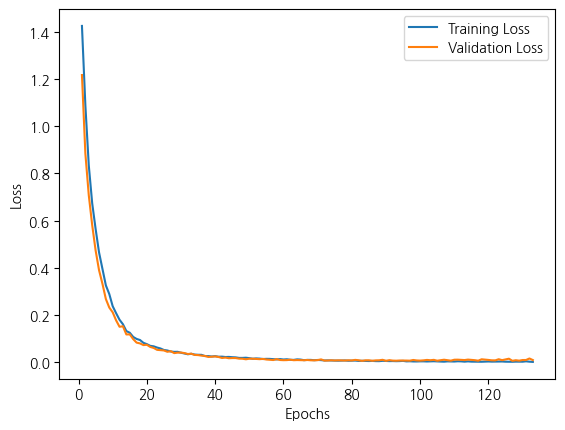

In [ ]:
import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_losses = []
val_losses = []

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate):
        super(TransformerModel, self).__init__()

        # Multihead Attention 레이어
        self.self_attention = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)

        # Feedforward 레이어
        self.feedforward = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)

        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(input_size)
        self.layer_norm2 = nn.LayerNorm(input_size)

        # Fully Connected 레이어 (분류를 위한)
        self.fc = nn.Linear(input_size, output_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # 어텐션 레이어 통과
        attention_output, _ = self.self_attention(x, x, x)
        x = x + self.dropout(attention_output)
        x = self.layer_norm1(x)

        # Feedforward 레이어 통과
        ff_output = self.feedforward(x)
        x = x + self.dropout(ff_output)
        x = self.layer_norm2(x)

        # Fully Connected 레이어 통과 (softmax를 사용하지 않음)
        x = self.fc(x)
        return x


    def get_attention_weights(self, x):
        # 어텐션 레이어 통과
        attention_output, weights = self.self_attention(x, x, x)
        return weights


# 모델 초기화 및 손실 함수, 옵티마이저 설정
input_size = X_train.shape[1]  # 입력 데이터의 특성 수
hidden_size = 128  # Feedforward 레이어의 히든 크기
output_size = y_train.shape[1]  # 클래스 수
num_layers = 2  # 트랜스포머 레이어의 수
num_heads = 4  # 어텐션 헤드의 수
dropout_rate = 0.1

model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제이므로 CrossEntropyLoss 사용
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 모델 훈련
num_epochs = 1000

# EarlyStopping 초기화
early_stopping = EarlyStopping(patience=50, delta=0, path='transformer_checkpoint(1).pt')

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Variable to store the training loss for this epoch

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()  # Accumulate the training loss

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)  # Save the average training loss for this epoch

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        all_predictions = []
        all_targets = []

        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

            # 예측값과 실제값을 리스트에 추가
            all_predictions.extend(val_outputs.cpu().numpy())
            all_targets.extend(val_targets.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)  # Save the validation loss for this epoch

        # ... (The rest of your validation code remains unchanged)
        # 정확도 계산
        predictions = np.argmax(all_predictions, axis=1)
        targets = np.argmax(all_targets, axis=1)
        accuracy = accuracy_score(targets, predictions)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        print(f'RMSE: {rmse:.4f}')


        # EarlyStopping 호출
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

# Plotting the training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 중요도(어텐션 weight) 시각화

In [ ]:
import torch
import matplotlib.pyplot as plt

# 모델 인스턴스 생성
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate).to(device)

# 학습된 모델 가중치 로드 (이미 학습된 모델의 가중치를 사용하는 경우)
model.load_state_dict(torch.load('/content/transformer_checkpoint(1).pt'))

# 모델을 평가 상태로 설정
model.eval()

# 입력 데이터의 데이터 타입 확인
sample_input = torch.tensor(X_train[0]).unsqueeze(0).to(device)
print("Input data type:", sample_input.dtype)

# 모델 가중치의 데이터 타입 확인
model_state_dict = model.state_dict()
for key, value in model_state_dict.items():
    print(f"{key}: {value.dtype}")

# 입력 데이터의 데이터 타입을 모델 가중치와 동일하게 맞추기
sample_input = sample_input.to(model_state_dict['self_attention.in_proj_weight'].dtype)

# 특정 입력에 대한 어텐션 가중치 얻기
attention_weights, _ = model.self_attention(sample_input, sample_input, sample_input)

# # 어텐션 가중치 시각화
# attention_weights = attention_weights.squeeze().cpu().detach().numpy()

# # 가장 간단한 형태로 변경 (예: (height, width))
# attention_weights = attention_weights.reshape((attention_weights.shape[0], -1))

# plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
# plt.xlabel('Input Sequence')
# plt.ylabel('Output Sequence')
# plt.title('Self-Attention Weights')
# plt.colorbar()
# plt.show()


Input data type: torch.float64
self_attention.in_proj_weight: torch.float32
self_attention.in_proj_bias: torch.float32
self_attention.out_proj.weight: torch.float32
self_attention.out_proj.bias: torch.float32
feedforward.0.weight: torch.float32
feedforward.0.bias: torch.float32
feedforward.2.weight: torch.float32
feedforward.2.bias: torch.float32
layer_norm1.weight: torch.float32
layer_norm1.bias: torch.float32
layer_norm2.weight: torch.float32
layer_norm2.bias: torch.float32
fc.weight: torch.float32
fc.bias: torch.float32


Input data type: torch.float64
self_attention.in_proj_weight: torch.float32
self_attention.in_proj_bias: torch.float32
self_attention.out_proj.weight: torch.float32
self_attention.out_proj.bias: torch.float32
feedforward.0.weight: torch.float32
feedforward.0.bias: torch.float32
feedforward.2.weight: torch.float32
feedforward.2.bias: torch.float32
layer_norm1.weight: torch.float32
layer_norm1.bias: torch.float32
layer_norm2.weight: torch.float32
layer_norm2.bias: torch.float32
fc.weight: torch.float32
fc.bias: torch.float32


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


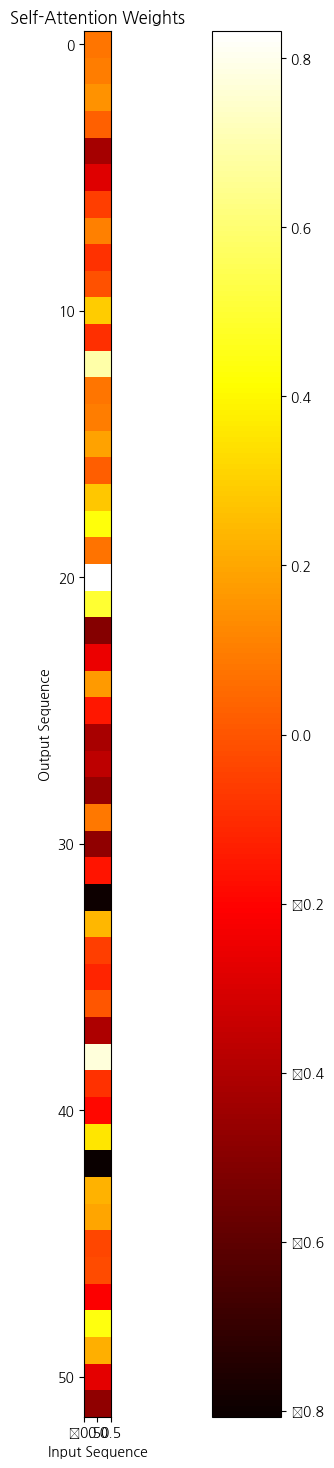

In [ ]:
import torch
import matplotlib.pyplot as plt

# 모델 인스턴스 생성
model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate).to(device)

# 학습된 모델 가중치 로드 (이미 학습된 모델의 가중치를 사용하는 경우)
model.load_state_dict(torch.load('/content/transformer_checkpoint(1).pt'))

# 모델을 평가 상태로 설정
model.eval()

# 입력 데이터의 데이터 타입 확인
sample_input = torch.tensor(X_train[0]).unsqueeze(0).to(device)
print("Input data type:", sample_input.dtype)

# 모델 가중치의 데이터 타입 확인
model_state_dict = model.state_dict()
for key, value in model_state_dict.items():
    print(f"{key}: {value.dtype}")

# 입력 데이터의 데이터 타입을 모델 가중치와 동일하게 맞추기
sample_input = sample_input.to(model_state_dict['self_attention.in_proj_weight'].dtype)

# 특정 입력에 대한 어텐션 가중치 얻기
attention_weights, _ = model.self_attention(sample_input, sample_input, sample_input)

# 어텐션 가중치 시각화
attention_weights = attention_weights.squeeze().cpu().detach().numpy()

# 가장 간단한 형태로 변경 (예: (height, width))
attention_weights = attention_weights.reshape((attention_weights.shape[0], -1))

# 그림의 크기를 두 배로 키우기
plt.figure(figsize=(26, 18))

plt.imshow(attention_weights, cmap='hot', interpolation='nearest')
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.title('Self-Attention Weights')
plt.colorbar()
plt.show()


In [ ]:
print(attention_weights.shape)
print(attention_weights.dtype)
#print(attention_weights)

(52, 1)
float32


In [ ]:
X_columns = df.iloc[:,3:-1].columns
X_columns

Index(['소득_구간_코드', '지출_총금액', '식료품_지출_총금액', '의류_신발_지출_총금액', '의료비_지출_총금액',
       '교통_지출_총금액', '여가_지출_총금액', '문화_지출_총금액', '교육_지출_총금액', '유흥_지출_총금액',
       '상권_변화_지표', '운영_영업_개월_평균', '폐업_영업_개월_평균', '서울_운영_영업_개월_평균',
       '서울_폐업_영업_개월_평균', '아파트_단지_수', '아파트_평균_시가', '총_생활인구_수', '남성_생활인구_수',
       '여성_생활인구_수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', '연령대_40_생활인구_수',
       '연령대_50_생활인구_수', '연령대_60_이상_생활인구_수', '시간대_1_생활인구_수', '시간대_2_생활인구_수',
       '시간대_3_생활인구_수', '시간대_4_생활인구_수', '시간대_5_생활인구_수', '시간대_6_생활인구_수',
       '월요일_생활인구_수', '화요일_생활인구_수', '수요일_생활인구_수', '목요일_생활인구_수', '금요일_생활인구_수',
       '토요일_생활인구_수', '일요일_생활인구_수', '집객시설_수', '종합병원_수', '일반_병원_수', '고등학교_수',
       '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수',
       '상권_구분_코드_D', '상권_구분_코드_R', '젠트리_여부'],
      dtype='object')

In [ ]:
attention_df = pd.DataFrame(index = X_columns)
attention_df['weight'] = attention_weights
attention_df= attention_df.sort_values(['weight'], ascending=False)
print(attention_df.shape)
attention_df

(52, 1)


,weight
연령대_10_생활인구_수,0.832598
집객시설_수,0.768885
폐업_영업_개월_평균,0.687780
연령대_20_생활인구_수,0.497196
버스_정거장_수,0.438066
남성_생활인구_수,0.431258
고등학교_수,0.355043
상권_변화_지표,0.291910
총_생활인구_수,0.279822
수요일_생활인구_수,0.239583


# 바차트로 시각화

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.font_manager as fm

#시스템에 설치된 폰트 목록 가져오기
font_list = fm.findSystemFonts()
print(font_list)

# 폰트 목록 출력
for font_path in font_list:
  font_properties = fm.FontProperties(fname=font_path)
  print(font_properties.get_name())

['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', 

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Matplotlib에서 나눔폰트 사용 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
import matplotlib.font_manager as fm

# 나눔폰트의 경로를 찾습니다.
nanum_font_path = fm.findfont(fm.FontProperties(family='NanumGothic'))

# 나눔폰트의 경로를 출력합니다.
print(f"나눔폰트 경로: {nanum_font_path}")

나눔폰트 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# # 나눔폰트의 경로를 지정합니다. 해당 경로는 위의 설치 명령어를 통해 확인할 수 있습니다.
# nanum_font_path = '/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/NanumSquareR.ttf'

# # 나눔폰트를 Matplotlib의 폰트 매니저에 추가합니다.
# fontprop = fm.FontProperties(fname=nanum_font_path)
# plt.rcParams['font.family'] = fontprop.get_name()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

Text(0.5, 1.0, '나눔폰트 샘플 그래프')

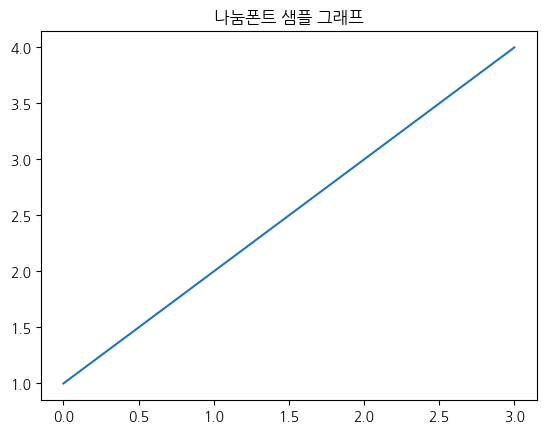

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum

# 폰트 캐시 재구성
!sudo fc-cache -fv

# Matplotlib 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

# 샘플 그래프 그리기
plt.plot([1, 2, 3, 4])
plt.title('나눔폰트 샘플 그래프')


<ipython-input-52-751c609d8ade>:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


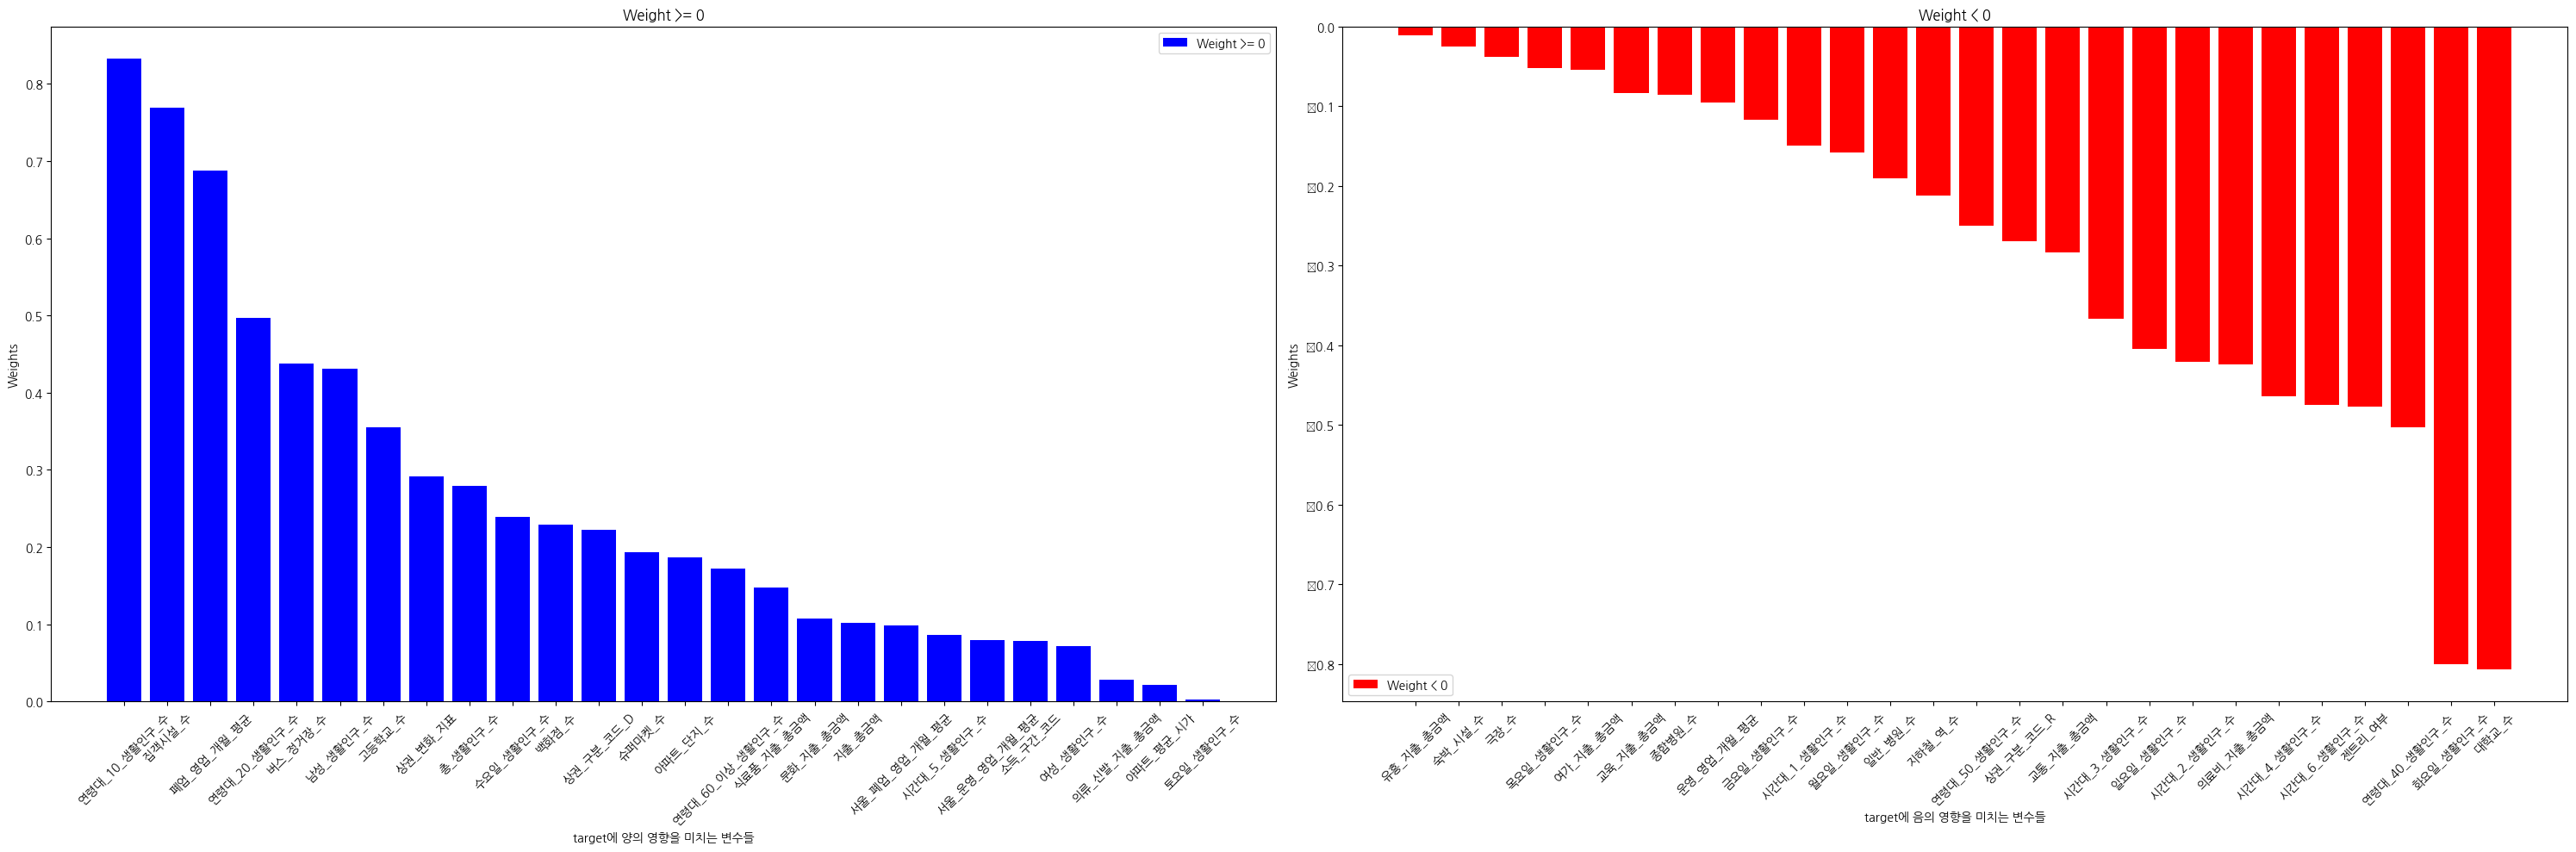

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

attention_df = attention_df

# 0 이상인 값만을 가지는 데이터프레임
df_positive = attention_df[attention_df['weight'] >= 0]

# 0 미만인 값만을 가지는 데이터프레임
df_negative = attention_df[attention_df['weight'] < 0]

# 그래프 영역 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

# 첫 번째 서브플롯: 0 이상인 값에 대한 바차트
axes[0].bar(df_positive.index, df_positive['weight'], color='b', label='Weight >= 0')
axes[0].set_title('Weight >= 0')
axes[0].set_xlabel('target에 양의 영향을 미치는 변수들')
axes[0].set_ylabel('Weights')
axes[0].legend()

# 두 번째 서브플롯: 0 미만인 값에 대한 바차트
axes[1].bar(df_negative.index, df_negative['weight'], color='r', label='Weight < 0')
axes[1].set_title('Weight < 0')
axes[1].set_xlabel('target에 음의 영향을 미치는 변수들')
axes[1].set_ylabel('Weights')
axes[1].legend()

# x축 레이블 45도 기울이기
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# 전체 그림의 레이아웃 조정
plt.tight_layout()

# 차트 표시
plt.show()


#2023 데이터에 적용해보기

In [ ]:
import pandas as pd
import torch

new_dataframe = pd.read_csv('/content/sample_data/newdata2023.csv')
new_dataframe

,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,의료비_지출_총금액,교통_지출_총금액,여가_지출_총금액,문화_지출_총금액,교육_지출_총금액,유흥_지출_총금액,상권_변화_지표,...,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수,상권_구분_코드_D,상권_구분_코드_R,상권_구분_코드_U,젠트리_여부
0,0.351616,0.309114,0.353085,0.313590,0.338070,0.362139,0.322095,0.236457,0.345741,0.333333,...,0.0,0.0,0.000000,0.125,0.25,0.923077,1.0,0.0,0.0,0.0
1,0.447806,0.415433,0.416040,0.427278,0.406323,0.339662,0.405436,0.343821,0.427554,0.666667,...,0.0,0.0,0.000000,0.000,0.00,0.423077,1.0,0.0,0.0,0.0
2,0.797254,0.697895,0.773575,0.710449,0.745487,0.767249,0.745689,0.579680,0.757471,0.333333,...,0.0,0.0,0.333333,0.000,0.50,0.423077,1.0,0.0,0.0,0.0
3,0.022728,0.027598,0.020436,0.026882,0.015775,0.016365,0.024570,0.007609,0.021500,0.333333,...,0.0,0.0,0.000000,0.250,0.00,0.076923,1.0,0.0,0.0,0.0
4,0.374667,0.379880,0.347252,0.396963,0.326120,0.282322,0.352331,0.214646,0.358738,0.666667,...,0.0,0.0,0.000000,0.000,0.00,0.230769,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.284623,0.293891,0.264035,0.296430,0.248073,0.190106,0.275909,0.165551,0.285616,0.000000,...,0.0,0.0,0.000000,0.000,0.00,0.038462,0.0,1.0,0.0,0.0
338,0.371890,0.363613,0.350966,0.370496,0.336707,0.277803,0.340762,0.248374,0.363154,0.000000,...,0.0,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0
339,0.288366,0.258393,0.279171,0.265896,0.271543,0.258855,0.253308,0.215221,0.278216,1.000000,...,0.0,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0
340,0.370849,0.341923,0.350887,0.334400,0.323566,0.276122,0.316061,0.329753,0.372277,0.666667,...,0.0,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0


In [ ]:
# 데이터프레임을 PyTorch Tensor로 변환
new_data_tensor = torch.tensor(new_dataframe.values, dtype=torch.float32)

# 모델을 GPU로 이동
model = model.to('cuda:0')

# 데이터를 GPU로 이동
new_data_tensor = new_data_tensor.to('cuda:0')

# 모델 예측 코드에 적용
with torch.no_grad():
    output = model(new_data_tensor)


In [ ]:
new_data_tensor

tensor([[0.3516, 0.3091, 0.3531,  ..., 0.0000, 0.0000, 0.0000],
        [0.4478, 0.4154, 0.4160,  ..., 0.0000, 0.0000, 0.0000],
        [0.7973, 0.6979, 0.7736,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2884, 0.2584, 0.2792,  ..., 1.0000, 0.0000, 0.0000],
        [0.3708, 0.3419, 0.3509,  ..., 1.0000, 0.0000, 0.0000],
        [0.0158, 0.0157, 0.0142,  ..., 1.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
tensor = torch.tensor([5])  # 이 텐서의 크기는 (1,)
scalar_value = tensor.item()  # 스칼라로 변환 시도
print(tensor)
print(scalar_value)

tensor([5])
5


In [ ]:
with torch.no_grad():
    output = model(new_data_tensor)
    print(output.numel())

1368


In [ ]:
import pandas as pd
import torch

# 모델 경로 지정
model_checkpoint_path = '/content/transformer_checkpoint.pt'

# 모델 초기화
loaded_model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_heads, dropout_rate).to(device)

# 저장된 가중치 불러오기
loaded_model.load_state_dict(torch.load(model_checkpoint_path))

# 새로운 데이터프레임 생성 및 텐서로 변환
new_data = pd.read_csv('/content/sample_data/newdata2023.csv')  # 실제 데이터에 맞게 열과 값을 채워주세요
new_data_tensor = torch.tensor(new_data.values, dtype=torch.float32).to(device)

# 모델 예측
loaded_model.eval()
with torch.no_grad():
    output = loaded_model(new_data_tensor)

# 예측 결과 확인
predictions = torch.argmax(output, dim=1).cpu().numpy()
print("Predictions:", predictions)


Predictions: [0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 3 1 1 1 0 1 0 0 0 0 1
 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1
 1 1 0 1 1 1 1 1 0 0 0 1 0 1 3 3 3 3 0 0 3 3 3 3 3 3 3 3 0 0 3 0 3 0 3 3 3
 3 3 3 0 3 3 3 0 3 3 3 3 0 3 3 3 3 3 3 0 3 3 3 3 0 0 3 0 3 3 3 3 3 3 3 3 0
 3 3 0 3 3 3 3 0 3 3 3 3 3 0 3 0 0 3 3 3 3 3 0 3 3 0 3 3 0 3 0 0 3 3 3 3 3
 3 0 3 3 3 3 0 3 3 3 3 3 3 3 0 0 3 3 3 0 0 3 0 0 3 3 0 3 3 3 3 0 3 3 0 3 3
 0 3 3 3 3 3 3 0 3 3 3 0 3 3 3 3 0 3 0 3 3 3 3 0 3 3 0 3 3 0 3 3 0 0 0 0 3
 3 3 0 0 0 0 3 0 3]


In [ ]:
predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3,
       3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0,
       3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3,

In [ ]:
new_dataframe['예측_clust'] = predictions
#finall_data
new_dataframe

,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,의료비_지출_총금액,교통_지출_총금액,여가_지출_총금액,문화_지출_총금액,교육_지출_총금액,유흥_지출_총금액,상권_변화_지표,...,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수,상권_구분_코드_D,상권_구분_코드_R,상권_구분_코드_U,젠트리_여부,예측_clust
0,0.351616,0.309114,0.353085,0.313590,0.338070,0.362139,0.322095,0.236457,0.345741,0.333333,...,0.0,0.000000,0.125,0.25,0.923077,1.0,0.0,0.0,0.0,0
1,0.447806,0.415433,0.416040,0.427278,0.406323,0.339662,0.405436,0.343821,0.427554,0.666667,...,0.0,0.000000,0.000,0.00,0.423077,1.0,0.0,0.0,0.0,1
2,0.797254,0.697895,0.773575,0.710449,0.745487,0.767249,0.745689,0.579680,0.757471,0.333333,...,0.0,0.333333,0.000,0.50,0.423077,1.0,0.0,0.0,0.0,0
3,0.022728,0.027598,0.020436,0.026882,0.015775,0.016365,0.024570,0.007609,0.021500,0.333333,...,0.0,0.000000,0.250,0.00,0.076923,1.0,0.0,0.0,0.0,1
4,0.374667,0.379880,0.347252,0.396963,0.326120,0.282322,0.352331,0.214646,0.358738,0.666667,...,0.0,0.000000,0.000,0.00,0.230769,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.284623,0.293891,0.264035,0.296430,0.248073,0.190106,0.275909,0.165551,0.285616,0.000000,...,0.0,0.000000,0.000,0.00,0.038462,0.0,1.0,0.0,0.0,0
338,0.371890,0.363613,0.350966,0.370496,0.336707,0.277803,0.340762,0.248374,0.363154,0.000000,...,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0,0
339,0.288366,0.258393,0.279171,0.265896,0.271543,0.258855,0.253308,0.215221,0.278216,1.000000,...,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0,3
340,0.370849,0.341923,0.350887,0.334400,0.323566,0.276122,0.316061,0.329753,0.372277,0.666667,...,0.0,0.000000,0.000,0.00,0.000000,0.0,1.0,0.0,0.0,0


In [ ]:
new_dataframe.to_csv('2023predict_12_12.csv',index=False, encoding='utf-8-sig')

트랜스포머 모델의 일반적인 특성은 시퀀스의 위치 정보와 각 단어 간의 상관 관계를 학습하는 데에 있습니다. 따라서 학습 데이터와 적용 데이터 간의 속성이 약간 다르더라도 모델은 일반적으로 이러한 차이에 대해 어느 정도의 일반화를 수행할 수 있습니다.

그러나 몇 가지 주의할 점이 있습니다:

입력 데이터의 범주가 학습 데이터와 동일한 범주에 속하는지 확인: 학습 데이터와 적용 데이터 간의 범주가 크게 다를 경우 모델의 성능이 저하될 수 있습니다. 예를 들어, 모델이 학습한 범주와 적용 시에 다른 범주 체계를 사용하는 경우, 모델의 성능은 예측이 어려울 수 있습니다.
학습 데이터와 적용 데이터의 크기 및 특성 차이 고려: 만약 학습 데이터와 적용 데이터의 크기나 특성이 크게 차이난다면, 모델이 적용 데이터에서 제대로 일반화되지 않을 수 있습니다. 특히 학습 데이터가 적은 경우에는 모델이 학습 데이터에 과적합되어 적용 데이터에서 성능이 낮아질 수 있습니다.
데이터 정규화 및 전처리 유지: 학습 데이터와 적용 데이터 간의 입력 속성이 다를 경우, 두 데이터에 동일한 전처리 및 정규화를 수행해야 합니다. 모델이 학습한 데이터의 분포에 맞춰 적용 데이터도 처리되어야 일반화가 잘 이루어집니다.
모델의 학습 범위: 모델이 학습한 데이터의 범위를 고려해야 합니다. 모델이 학습한 데이터의 범위를 벗어나는 새로운 속성이 적용 데이터에 포함된 경우, 모델이 적절한 예측을 수행하지 못할 수 있습니다.
학습 데이터와 적용 데이터 간의 속성 차이를 최소화하고 모델의 성능을 유지하기 위해서는 가능한 한 유사한 데이터를 사용하여 모델을 학습하고 적용해야 합니다. 이러한 과정을 통해 모델이 보다 일반적인 특성을 학습하고 새로운 데이터에 대해 효과적으로 예측할 수 있게 됩니다.